this notebook reproduces figures from the https://doi.org/10.3390/rs13061098
# NOT MEANT FOR S3_loader testing or demo

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from xarray import open_dataset
import numpy as np
from geopy.distance import distance
import sqlite3

# Functions

In [44]:
def join_extraction(extr_dir):
    names = [x.name.replace('.log', '') for x in Path(extr_dir).glob('*.log')]  # a trick to get names
    df_all = pd.DataFrame()
    for name in names:
        df_pix = pd.read_csv(Path(extr_dir, f'{name}_OL_1_EFR_measurements.txt'), comment='#', sep='\t', index_col='ProdID')
        df_prod = pd.read_csv(Path(extr_dir, f'{name}_productIdMap.txt'), comment='#', sep='\t', index_col='ProductID')
        if df_pix.shape[0] != df_prod.shape[0]:
            print('n rows mismatch: less names than products?!')
        
        df_joined = df_prod.join(df_pix)
        if df_pix.shape[0] != df_joined.shape[0]:
            print(f'expected {df_pix.shape[0]}, resulted {df_joined.shape[0]}')
        
        df_joined['name'] = df_joined.ProductLocation.apply(lambda x: Path(x).parent.name.replace('.SEN3', ''))
        
        df_joined['m_to_tower_tp'] = df_joined.apply(lambda row: get_distance(row.TP_latitude, row.TP_longitude), axis=1)
        df_joined['m_to_tower_geo'] = df_joined.apply(lambda row: get_distance(row.latitude, row.longitude), axis=1)
        df_joined['m_to_tower_extraction'] = df_joined.apply(lambda row: get_distance(row.Latitude, row.Longitude), axis=1)
        
        df_all = df_all.append(df_joined)
#     df_all = add_flags(df_all)
#     df_all = drop_not_sql(df_all)
    df_all['gee_name'] = df_all.name.str[:47].str.replace('OL_1_EFR____', '')
    df_all.index = pd.to_datetime(df_all.name.str[16:31])  #  pd.to_datetime(df['Date(yyyy-MM-dd)'] + ' ' + df['Time(HH_mm_ss)'])
    df_all.index.name = 'dt'
    return df_all


def get_distance(m_lat, m_lon, lat=52.251185, lon=5.690051):
    if np.isnan(m_lat):
        return np.nan
    return distance((lat, lon), (m_lat, m_lon)).meters
    

def read_gee(gee_path):
    gee = pd.read_csv(gee_path)
    gee = decode_flags(gee)
    gee.index = pd.to_datetime(gee['system:index'].str[4:19])
    gee.index.name = 'dt'
    gee['name'] = gee.product_id
    gee['m_to_tower_geo'] = gee.apply(lambda row: get_distance(row.latitude, row.longitude), axis=1)
    gee['width'] = gee.x_max - gee.x_min  # 45 -(-1)
    gee['height'] = gee.y_max - gee.y_min
    gee['x_cor'] = gee.x - gee.x_min 
    gee['y_cor'] = gee.y - gee.y_min 
    return gee

def satvap(T):
    if np.all(T > 200):
        T = T - 273.15
    a = 7.5
    b = 237.3
    es = 6.107*10 ** (7.5 *T /(b + T))
    return es

def abline(slope, intercept, ax):
    """
    Plot a line from slope and intercept
    https://stackoverflow.com/a/43811762 modified from David Marx
    """
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, 'k--')

# Meteorological data figures

Meteorological data was taken for January 2020 to ease comparison. 

In the `S3_loader` package `example.py` 
1. set `period = ('2020-01-01', '2020-01-31')` (Line 31) to start the download
2. uncomment L62, L64, L65 to extract the pixel time series with SNAP gpt tool
3. once downloaded and extracted provide the path below

In [46]:
extracted_dir_path = r'D:\PyCharm_projects\S3_loader\example_extracted'
# extracted_dir_path = r'D:\PyCharm_projects\Spe\gee\olci_extracted_geo'
df = join_extraction(extracted_dir_path)
df.shape

(2, 174)

In [29]:
df.head()

,ProductType,ProductLocation,CoordID,Name,Latitude,Longitude,PixelX,PixelY,Date(yyyy-MM-dd),Time(HH_mm_ss),...,quality_flags_saturated_Oa17,quality_flags_saturated_Oa18,quality_flags_saturated_Oa19,quality_flags_saturated_Oa20,quality_flags_saturated_Oa21,name,m_to_tower_tp,m_to_tower_geo,m_to_tower_extraction,gee_name
dt,,,,,,,,,,,,,,,,,,,,,
2016-05-08 09:27:58,OL_1_EFR,/home/prikaziuke/spe_loader/full/olci/S3A_OL_1...,1,test_0_0,52.251070,5.693562,236.5,40.5,2016-05-08,09:27:59,...,0,0,0,0,0,S3A_OL_1_EFR____20160508T092758_20160508T09285...,86.594316,240.131482,240.118109,S3A_20160508T092758_20160508T092852
2016-05-17 10:32:17,OL_1_EFR,/home/prikaziuke/spe_loader/full/olci/S3A_OL_1...,1,test_0_0,52.251832,5.691816,4384.5,3294.5,2016-05-17,10:34:42,...,0,0,0,0,0,S3A_OL_1_EFR____20160517T103217_20160517T10351...,319.377150,140.336827,140.399349,S3A_20160517T103217_20160517T103517
2016-06-05 10:39:46,OL_1_EFR,/home/prikaziuke/spe_loader/full/olci/S3A_OL_1...,1,test_0_0,52.251432,5.689126,4827.5,3137.5,2016-06-05,10:42:03,...,0,0,0,0,0,S3A_OL_1_EFR____20160605T103946_20160605T10424...,158.611219,68.823905,68.890738,S3A_20160605T103946_20160605T104246
2016-08-11 10:02:22,OL_1_EFR,/home/prikaziuke/spe_loader/full/olci/S3A_OL_1...,1,test_0_0,52.251455,5.688680,2566.5,3766.5,2016-08-11,10:05:07,...,0,0,0,0,0,S3A_OL_1_EFR____20160811T100222_20160811T10052...,247.361425,98.265974,98.331422,S3A_20160811T100222_20160811T100522
2016-09-30 10:06:06,OL_1_EFR,/home/prikaziuke/spe_loader/full/olci/S3A_OL_1...,1,test_0_0,52.250934,5.690994,2796.5,3811.5,2016-09-30,10:08:53,...,0,0,0,0,0,S3A_OL_1_EFR____20160930T100606_20160930T10090...,219.121690,70.155896,70.195891,S3A_20160930T100606_20160930T100906


## Figure 7

### CAMS reading - interpolation

CAMS data is available through Copernicus Atmosphere Data Store (ADS) at **coarser resolution** that was used in the paper 0.75 vs 0.125 arc-degrees
https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-reanalysis-eac4?tab=form

corresponding variable names can be found in Section 2.3.2. Meteo:

Variables at Surface (Single in ADS) level:
- total column water vapor (tcwv, 137)
- total column ozone (gtco3, 210206) from GEMS
- mean sea level pressure (msl, 151)
- 10 meter U and V wind components (horizontal wind vectors u10, v10)

Relative humidity at 850 hPa is not available anymore at Pressure (Multi in ADS) level.

In [30]:
jan = df.sort_index()['2020-01-01': '2020-01-31']
lat = 52.251185
lon = 5.690051

In [75]:
cams_surface_path = r"D:\PyCharm_projects\S3_loader\adaptor.mars.internal-1626186074.9948747-30868-5-9ee89b86-7231-4124-8ed8-58e8fc1986c0.nc"
nc = open_dataset(cams_surface_path)
nc_int = nc.interp(dict(latitude=lat, longitude=lon, time=jan.index))
nc.close()

In [68]:
## humidity @850hPa
cams_pressure_path = r"D:\PyCharm_projects\S3_loader\q_ta.nc"
nc = open_dataset(cams_pressure_path)
nc_h_int = nc.interp(dict(latitude=lat, longitude=lon, time=jan.index))
nc.close()

MH2O = 18
Mair = 29
p = 850
e_to_q      = MH2O/Mair/p  # e = q / e_to_q

ea = nc_h_int.q / e_to_q
es = satvap(nc_h_int.t)

rh = ea / es * 100
nc_int = nc_int.merge({'r': rh})

In [25]:
pairs = {
    'tcwv': ('total_columnar_water_vapour', r'${\rm kg\ m^{-2}}$'),
    'gtco3': ('total_ozone', r'$\rm kg\ m^{-2}$'),
    'msl': ('sea_level_pressure', r'$\rm hPa$'),
    'u10': ('horizontal_wind_vector_1', r'$\rm m\ s^{-1}$'),
    'v10': ('horizontal_wind_vector_2', r'$\rm m\ s^{-1}$'),
    'r': ('humidity', r'%')  # relative humidity @850hPa
}

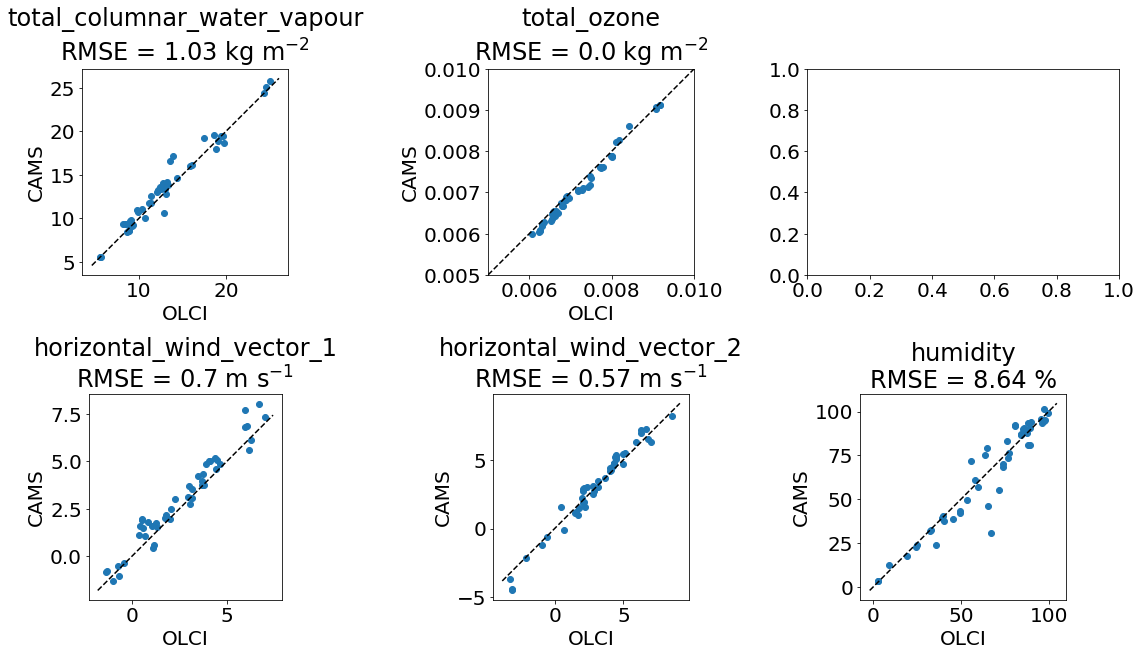

In [79]:
plt.rcParams.update({'font.size': 20})

_, axs = plt.subplots(2, 3, figsize=(16, 9), constrained_layout=True)

axs = axs.flatten()
for i, k in enumerate(pairs):
    ax = axs[i]
    name, units = pairs[k]
    x = jan[name]
    if k not in nc_int:
        continue
    y = nc_int[k].copy()
    if k == 'msl':
        y /= 100
    elif k == 'd2m':
        ta = nc_int['t2m'] - 273.15
        ea = satvap(y - 273.15)
        es = satvap(ta)
        y = ea / es * 100      
    ax.scatter(x, y)
    if k == 'd2m':
        ax.scatter(x, nc_h_int.q * 1e2)
        ax.legend(['relative, %', 'specific, %'])
        ax.set_title(name)
    else:
        rmse = np.sqrt(np.mean((x - y) ** 2))
        ax.set_title(f'{name}\nRMSE = {round(rmse, 2)} {units}')
    
    if k == 'gtco3':
        ax.set_xlim([0.005, 0.010])
        ax.set_ylim([0.005, 0.010])
    ax.set_xlabel('OLCI')
    ax.set_ylabel('CAMS')
    abline(1, 0, ax)
    ax.set_aspect('equal', 'box')

## Figure 8

### CAMS reading - interpolation

CAMS data is available through Copernicus Atmosphere Data Store (ADS) at **coarser resolution** that was used in the paper 0.75 vs 0.125 arc-degrees
https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-reanalysis-eac4?tab=form

corresponding variable names can be found in Section 2.3.2. Meteo:

- Temperature at Pressure (Multi in ADS) level (all 25 pressure levels from 1 to 1000 hPa)

In [39]:
jan = df.sort_index()['2020-01-01': '2020-01-31']
lat = 52.251185
lon = 5.690051

In [40]:
cams_pressure_path = r"D:\PyCharm_projects\S3_loader\levtype_pl.nc"
nc_pressure = open_dataset(cams_pressure_path)
nc_p_int = nc_pressure.interp(dict(latitude=lat, longitude=lon, level=nc_pressure.level, time=jan.index))
nc_pressure.close()

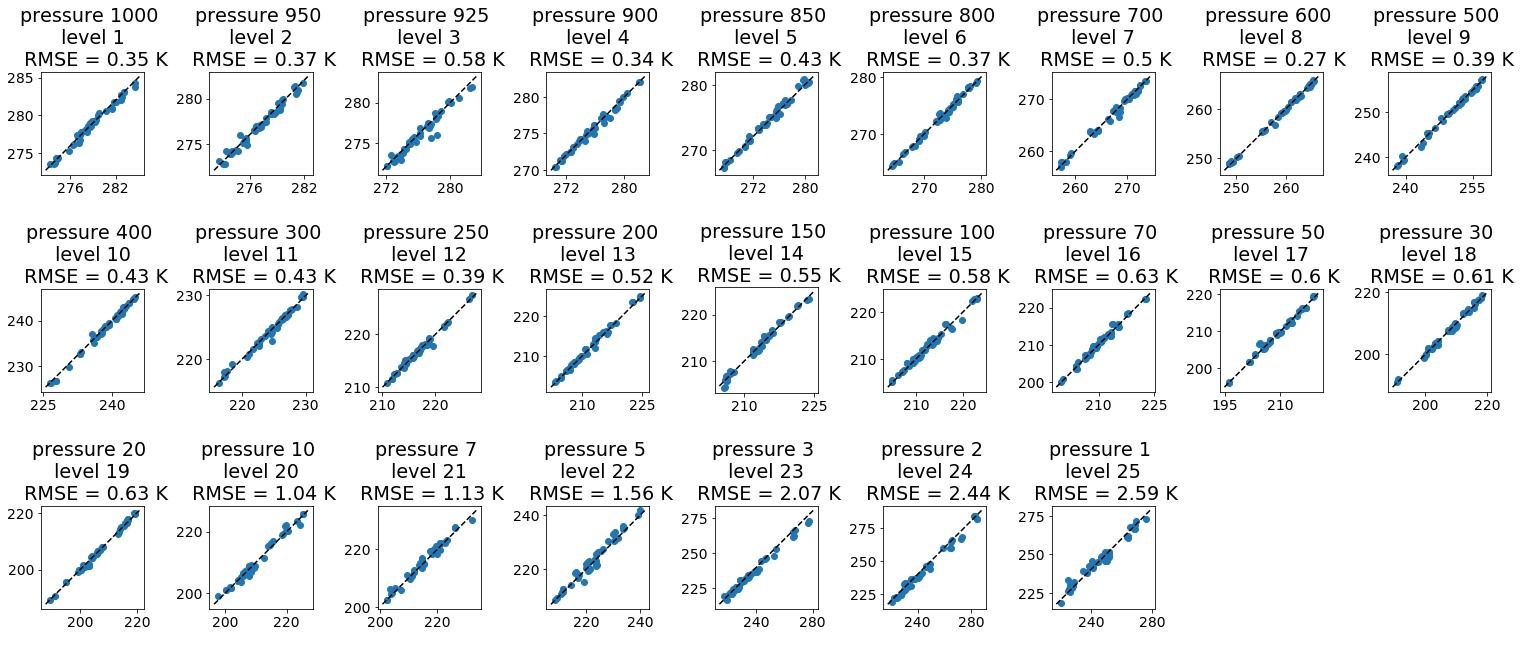

In [43]:
levels = nc_p_int.level.values[::-1]

plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(3, 9, figsize=(21, 9), constrained_layout=True)

axs = axs.flatten()
for i in range(len(levels)):
    ax = axs[i]
    x = jan[f'atmospheric_temperature_profile_pressure_level_{i+1}']
    pressure = levels[i]
    y = nc_p_int.sel(level=pressure).t
    ax.scatter(x, y)
    rmse = np.sqrt(np.mean((x - y) ** 2))
    ax.set_title(f'pressure {pressure} \n level {i+1} \n RMSE = {round(rmse, 2)} K')
    abline(1, 0, ax)
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.MaxNLocator(2))
    ax.tick_params(axis='both', which='major', labelsize=14)
fig.delaxes(axs[i+1])
fig.delaxes(axs[i+2])

# Complete dataset figures

ideally should be done with exclusions

In [44]:
# for quality flag decoding
olci_image_path = r"D:\PyCharm_projects\Spe\subset\olci\S3A_OL_1_EFR____20190101T093149_20190101T093449_20190102T140758_0179_039_364_2160_LN1_O_NT_002.nc"
db_path = r"D:\PyCharm_projects\S3_loader\NL_Spe_olci_copy.db"
qc_single_csv = r"D:\PyCharm_projects\Spe\gee\quality_flags_geo.csv"

def drop_not_sql(df, db_path=db_path):
    df_db = pd.read_sql('SELECT * FROM OL_1_EFR___', sqlite3.connect(db_path))
    return df[df.name.isin(df_db.name)]


def add_flags(df, qc_singe_csv=qc_single_csv):
    # single band quality_flags is exported wrongly, but single bands are there
    df_geo = pd.read_csv(qc_single_csv, index_col='name')
    qc = df_geo.qc.str.strip('[]').astype(np.uint32)
    df = df.set_index('name')
    df = df.join(qc)
    return df.reset_index()


def decode_flags(df_gee, olci_path=olci_image_path):
    nc = open_dataset(olci_path)
    df_flags_gee = df_gee.quality_flags.map(lambda x: (nc.quality_flags.flag_masks & int(x)).astype(bool).astype(int) if not np.isnan(x) else [np.nan])
    qc_names = [f'quality_flags_{x}' for x in nc.quality_flags.flag_meanings.split()]
    nc.close()
    df_flags_gee = pd.DataFrame(df_flags_gee.tolist(), columns=qc_names, index=df_flags_gee.index)
    return df_gee.join(df_flags_gee)


## Reading

GEE file from https://code.earthengine.google.com/61fe01512385e06b5bc3f65f78bef692?noload=true

DHUS from ``S3_loader`` for the whole period

In [47]:
df = join_extraction(r'D:\PyCharm_projects\Spe\gee\olci_extracted_geo')

In [53]:
gee = read_gee(r"D:\PyCharm_projects\Spe\gee\s3_spe_300m.csv")

In [49]:
gee.shape

(2044, 81)

In [50]:
df.shape, gee.shape

((2020, 174), (2044, 81))

In [145]:
# df.to_csv(r'D:\PyCharm_projects\Spe\gee\final\dhus.csv')
# gee.to_csv(r'D:\PyCharm_projects\Spe\gee\final\gee.csv')

In [135]:
df = pd.read_csv(r'D:\PyCharm_projects\Spe\gee\final\dhus.csv', index_col='dt', parse_dates=True)
gee = pd.read_csv(r'D:\PyCharm_projects\Spe\gee\final\gee.csv', index_col='dt', parse_dates=True)

## Figure 3
### Plotting distance

In [164]:
300*np.sqrt(2) / 2, 318*np.sqrt(2) / 2

(212.13203435596427, 224.85995641732214)

Text(0.5, 1.0, 'GEE')

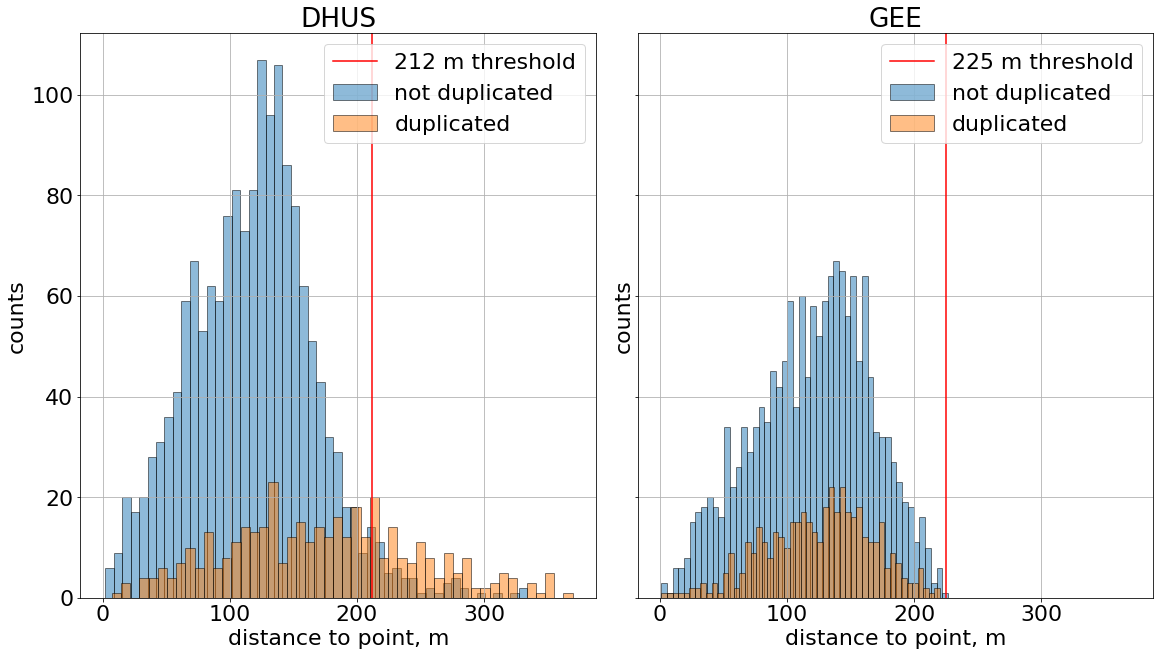

In [51]:
plt.rcParams.update({'font.size': 22})
# df_pix = df
_, axs = plt.subplots(1, 2, figsize=(16, 9), edgecolor='black', constrained_layout=True, sharey=True, sharex=True)

ax = axs[0]
df.groupby(df.quality_flags_duplicated).m_to_tower_geo.hist(ax=ax, alpha=0.5, bins=50, edgecolor='black')
# df.m_to_tower_tp.hist(ax=ax, alpha=0.5, edgecolor='black', bins=50, label='tie-point')
# df.m_to_tower_extraction.hist(ax=ax, alpha=0.5, bins=50, edgecolor='black', label='extraction coordinates')
ax.axvline(212, c='r')
ax.set_xlabel('distance to point, m')
ax.set_ylabel('counts')
ax.legend(['212 m threshold', 'not duplicated','duplicated'], loc=1)
ax.set_title('DHUS')

ax = axs[1]
gee.groupby(gee.quality_flags_duplicated).m_to_tower_geo.hist(ax=ax, alpha=0.5, bins=50, edgecolor='black')
ax.axvline(225, c='r')
ax.set_xlabel('distance to point, m')
ax.set_ylabel('counts')
ax.legend(['225 m threshold', 'not duplicated','duplicated'], loc=1)
ax.set_title('GEE')
# plt.savefig(r'D:\papers\gee_olci\proofread\figures\3_distance_to_spe_cor.pdf')

## Table 1
### Joining

In [149]:
# on full without any exclusions
len(df.name[df.name.isin(gee.name)]), len(df.gee_name[df.gee_name.isin(gee['system:index'])]), df.shape, gee.shape

(1146, 1887, (1908, 175), (2045, 74))

In [150]:
df.Oa01_radiance.count(), gee.Oa01_radiance.count()

(1779, 1879)

In [159]:
df = df[~df.Oa01_radiance.isna()]
gee = gee[~gee.Oa01_radiance.isna()]  # 1709 prod_ids
df.shape, gee.shape

((1779, 175), (1879, 74))

In [152]:
gee.product_id.isna().sum()

307

In [153]:
# df = df[~df.index.isin(gee.index[gee.product_id.isna()])]
gee = gee[~gee.product_id.isna()]
df.shape, gee.shape

((1779, 175), (1572, 74))

In [154]:
names_in = df.name[df.name.isin(gee.name)]
len(names_in)

1065

In [155]:
len(df.name[df.name.isin(gee.name)]), len(df.gee_name[df.gee_name.isin(gee['system:index'])]), df.shape, gee.shape

(1065, 1554, (1779, 175), (1572, 74))

Let's see for the non-matching images with full name present what is the reason

1. 211 SVL
2. 300 (211+89) NR
3. 220 ? - reprocessed

In [257]:
gee_short = gee[gee['system:index'].isin(names_in_short) & ~gee.name.isna()]# .name.values #.str.contains('NR').sum()
(~gee_short.name.str.contains('SVL') & gee_short.name.str.contains('NR')).sum(), gee_short.shape
gee_short = gee_short[~gee_short.name.str.contains('SVL') & ~gee_short.name.str.contains('NR')]
gee_short.shape
df.reset_index().set_index('gee_name').loc[gee_short['system:index'], ['name']].to_csv(r'D:\PyCharm_projects\Spe\gee\final\dhus_full_no-match.csv')
gee.reset_index().set_index('system:index').loc[gee_short['system:index'], ['product_id']].to_csv(r'D:\PyCharm_projects\Spe\gee\final\gee_full_no-match.csv')

GEE with missing full name

In [267]:
gee[gee['system:index'].isin(names_in_short) & gee.name.isna()].shape, gee.name.isna().sum()

((221, 74), 336)

In [271]:
gee[~gee['system:index'].isin(names_in_short) & ~gee.name.isin(names_in)].name.isna().sum()

115

In [276]:
gee[~gee['system:index'].isin(names_in_short) & ~gee.name.isin(names_in)].Oa01_radiance.isna().sum()

36

Short not matched

In [275]:
df[~df.gee_name.isin(names_in_short) & ~df.name.isin(names_in)][['name', 'gee_name']].to_csv(r'D:\PyCharm_projects\Spe\gee\final\dhus_short_no-match.csv')
gee[~gee['system:index'].isin(names_in_short) & ~gee.name.isin(names_in)][['name', 'system:index']].to_csv(r'D:\PyCharm_projects\Spe\gee\final\gee_short_no-match.csv')

## Figure 4
### Plotting rmse

In [139]:
names_in = df.name[df.name.isin(gee.name)]
len(names_in)

1146

In [140]:
names_in_short = df.gee_name[~df.name.isin(gee.name) & df.gee_name.isin(gee['system:index'])]
len(names_in_short)

741

In [141]:
bands = [x for x in gee.columns if x.startswith('Oa')]
len(bands)

21

In [142]:
df_esa = df.reset_index().set_index('name').loc[names_in]
df_gee = gee.reset_index().set_index('name').loc[names_in]
rmse_full = (df_esa[bands] - df_gee[bands]).pow(2).mean(axis=1).pow(0.5)

df_esa = df.reset_index().set_index('gee_name').loc[names_in_short]
df_gee = gee.reset_index().set_index('system:index').loc[names_in_short]
rmse_short = (df_esa[bands] - df_gee[bands]).pow(2).mean(axis=1).pow(0.5)

In [143]:
rmse_full.shape, rmse_short.shape

((1146,), (741,))

In [11]:
rmse_full.median(), (rmse_full < 2).sum(), rmse_short.median(), (rmse_short < 2).sum()

(2.1784298597826055, 497, 2.5659179421632325, 309)

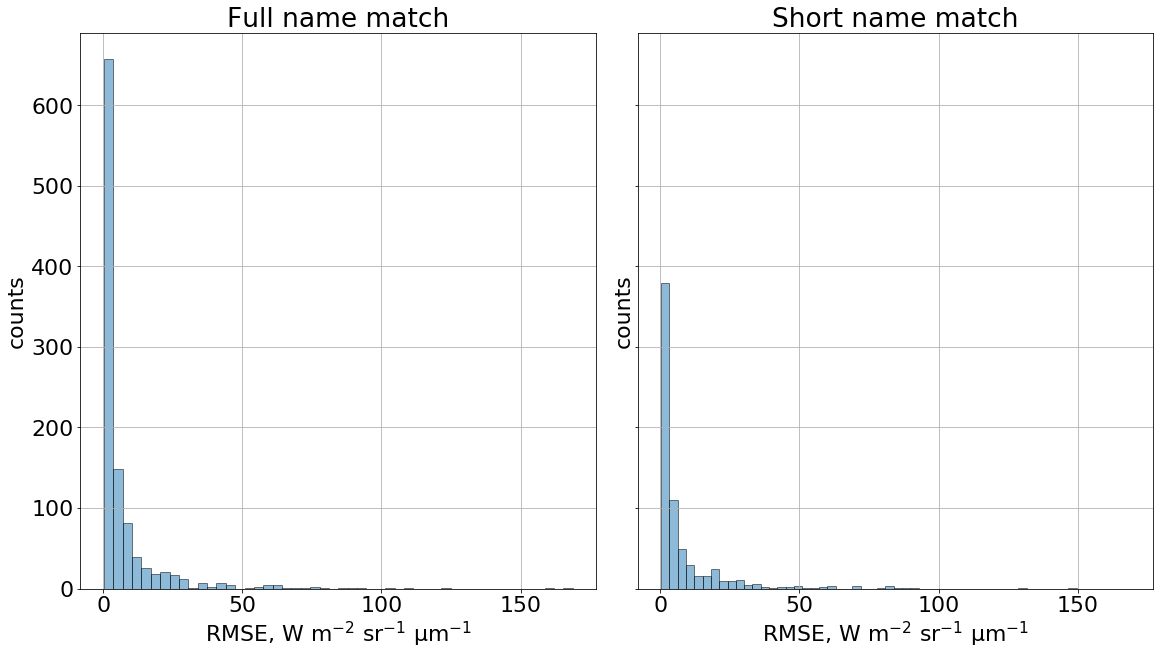

In [145]:
plt.rcParams.update({'font.size': 22})
# df_pix = df
_, axs = plt.subplots(1, 2, figsize=(16, 9), edgecolor='black', constrained_layout=True, sharey=True, sharex=True)

ax = axs[0]

rmse_full.hist(ax=ax, alpha=0.5, bins=50, edgecolor='black')
ax.set_xlabel(r'RMSE, $\rm W\ m^{-2}\ sr^{-1}\ \mu m^{-1}$')
ax.set_ylabel('counts')
ax.set_title('Full name match')

ax = axs[1]
# rmse_short[~rmse_short.index.isin(gee_short['system:index'])].hist(ax=ax, alpha=0.5, bins=50, edgecolor='black')
rmse_short.hist(ax=ax, alpha=0.5, bins=50, edgecolor='black')
ax.set_xlabel(r'RMSE, $\rm W\ m^{-2}\ sr^{-1}\ \mu m^{-1}$')  
ax.set_ylabel('counts')
ax.set_title('Short name match')

# plt.savefig(r'D:\papers\gee_olci\proofread\figures\4_rmse_spe_cor.pdf')

## Figure 5
### Bars

Requires even more data: 1x1 and 3x3 extraction from GEE and DHUS

In [265]:
gee = pd.read_csv(r'D:\PyCharm_projects\Spe\gee\final\gee.csv', index_col='dt', parse_dates=True)
gee3 = read_gee(r"D:\PyCharm_projects\Spe\gee\s3_spe_buff500_3.csv")

df = pd.read_csv(r'D:\PyCharm_projects\Spe\gee\final\dhus.csv', index_col='dt', parse_dates=True)
df3 = pd.read_csv(r'D:\PyCharm_projects\Spe\gee\final\dhus_3x3_mean.csv', index_col='dt', parse_dates=True)
df_tp = pd.read_csv(r'D:\PyCharm_projects\Spe\gee\final\dhus_tp.csv', index_col='dt', parse_dates=True)
df_tp3 = pd.read_csv(r'D:\PyCharm_projects\Spe\gee\final\dhus_3x3_mean_tp.csv', index_col='dt', parse_dates=True)

In [151]:
df.shape, df3.shape, df_tp.shape, df_tp3.shape

((1908, 175), (1908, 170), (1682, 176), (1682, 180))

In [130]:
common = df.gee_name[df.gee_name.isin(gee['system:index'])]
bands = [x for x in gee.columns if x.startswith('Oa')]
len(common),len(bands)

(1887, 21)

In [266]:
df_gee = gee.reset_index().set_index('system:index').loc[common]
df_gee3 = gee3.reset_index().set_index('system:index').loc[common]
df_esa = df.reset_index().set_index('gee_name').loc[common]
df3_esa = df3.reset_index().set_index('gee_name').loc[common]
df_tp_esa = df_tp.reset_index().set_index('gee_name').loc[common]
df_tp3_esa = df_tp3.reset_index().set_index('gee_name').loc[common]

C:\Miniconda\envs\plot\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """
C:\Miniconda\envs\plot\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


In [150]:
df_esa.shape, df3_esa.shape, df_tp_esa.shape, df_tp3_esa.shape

((1887, 175), (1887, 170), (1887, 176), (1887, 180))

In [304]:
def get_rmse(df_esa, df_gee):
    mean = df_esa[bands].mean()
    rmse = (df_esa[bands] - df_gee[bands]).pow(2).mean(axis=0).pow(0.5)
    return rmse / mean * 100
#     return rmse

In [154]:
# rmse = (df_esa[bands] - df_gee[bands]).pow(2).mean(axis=0).pow(0.5)
# rmse3 = (df3_esa[bands] - df_gee[bands]).pow(2).mean(axis=0).pow(0.5)
# rmse_tp = (df_tp_esa[bands] - df_gee[bands]).pow(2).mean(axis=0).pow(0.5)
# rmse_tp3 = (df_tp3_esa[bands] - df_gee[bands]).pow(2).mean(axis=0).pow(0.5)

In [305]:
rmse = get_rmse(df_esa[bands], df_gee3[bands])
rmse3 = get_rmse(df3_esa[bands], df_gee3[bands])
rmse_tp = get_rmse(df_tp_esa[bands], df_gee3[bands])
rmse_tp3 = get_rmse(df_tp3_esa[bands], df_gee3[bands])
df_vs3 = pd.concat([rmse, rmse3, rmse_tp, rmse_tp3], names=['geo', 'geo 3x3', 'tp', 'tp 3x3'], axis=1)
df_vs3 = pd.concat([rmse3, rmse_tp3], names=['geo 3x3', 'tp 3x3'], axis=1)

In [306]:
rmse = get_rmse(df_esa[bands], df_gee[bands])
rmse3 = get_rmse(df3_esa[bands], df_gee[bands])
rmse_tp = get_rmse(df_tp_esa[bands], df_gee[bands])
rmse_tp3 = get_rmse(df_tp3_esa[bands], df_gee[bands])
df_vs = pd.concat([rmse, rmse3, rmse_tp, rmse_tp3], names=['geo', '3x3', 'tp', 'tp 3x3'], axis=1)
df_vs = pd.concat([rmse, rmse_tp], names=['geo', 'tp'], axis=1)

In [195]:
df_vs.index.str[:4]

Index(['Oa01', 'Oa02', 'Oa03', 'Oa04', 'Oa05', 'Oa06', 'Oa07', 'Oa08', 'Oa09',
       'Oa10', 'Oa11', 'Oa12', 'Oa13', 'Oa14', 'Oa15', 'Oa16', 'Oa17', 'Oa18',
       'Oa19', 'Oa20', 'Oa21'],
      dtype='object')

In [211]:
import matplotlib.ticker as mtick

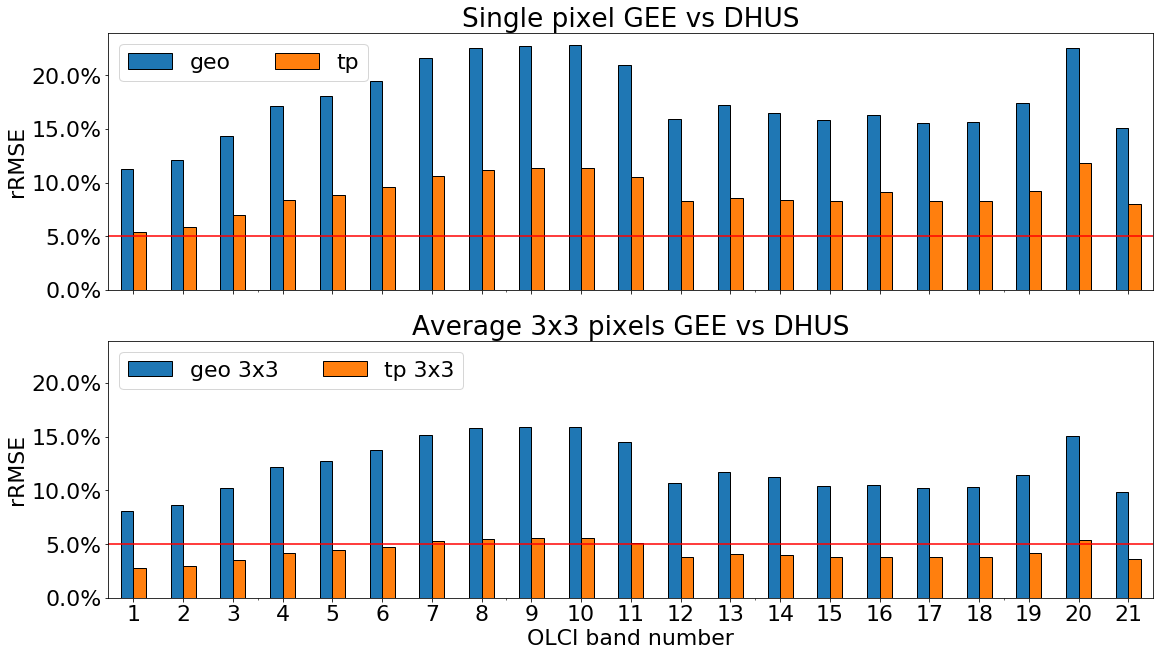

In [312]:
# df_pix = df
plt.rcParams.update({'font.size': 22})
_, axs = plt.subplots(2, 1, figsize=(16, 9), edgecolor='black', constrained_layout=True, sharey=True, sharex=True)

rot = 0  # 0
leg_loc = 2  # 1 - left, 2 - right: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.legend.html
tag = 'GEE vs DHUS'  # 'GEE'
metric = 'not'  #  'radiance', 'not'

ax = axs[0]

df_vs.plot.bar(ax=ax, legend=None, edgecolor='black')
ax.set_xlabel('OLCI band number')
if metric == 'radiance':
    ylab = r'RMSE, $W\ m^{-2}$'
    leg_loc = 1
else:
    ylab = 'rRMSE'
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel(ylab)
# ax.legend(['geo', '3x3', 'tp', 'tp 3x3'], loc='center left', bbox_to_anchor=(1, 0.5));
labels = list(range(1, 22))
ax.set_xticklabels(labels, rotation=rot)
ax.set_title(f'Single pixel {tag}')
ax.legend(['geo', 'tp'], ncol=2, loc=leg_loc)
if metric != 'radiance':
    ax.axhline(5, c='r')

ax = axs[1]
df_vs3.plot.bar(ax=ax, edgecolor='black')
ax.set_xlabel('OLCI band number')
ax.set_xticklabels(labels, rotation=rot)
ax.set_ylabel(ylab)
ax.set_title(f'Average 3x3 pixels {tag}')
ax.legend(['geo 3x3', 'tp 3x3'], ncol=2, loc=leg_loc)
if metric != 'radiance':
    ax.axhline(5, c='r')

# ax.legend(['geo', 'geo 3x3', 'tp', 'tp 3x3'], loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.5));


# plt.savefig(r'D:\papers\gee_olci\figures\rrmse2.pdf')

# Augmentation

# Figure 6
## Angles

In [146]:
gee.relative_orbit_num.isna().sum()

0

In [147]:
orbits = pd.concat([gee.relative_orbit_num[gee.name.isna()].value_counts(), gee.relative_orbit_num[~gee.name.isna()].value_counts()], axis=1)
    #.dropna().astype(int).to_csv(r'D:\PyCharm_projects\Spe\gee\final\orbits.csv')

In [149]:
orbits.count(), orbits.shape

(relative_orbit_num    22
 relative_orbit_num    33
 dtype: int64, (33, 2))

In [148]:
orbit_n = orbits.dropna().index.values

In [150]:
df['orbit'] = df.name.str[73:76].astype(int)
# pd.concat([df.orbit.value_counts(), gee.relative_orbit_num.value_counts()], axis=1)

In [151]:
angles = df[df.orbit.isin(orbit_n)].groupby('orbit').first()[['OZA', 'OAA']]

In [159]:
gee_angles = gee.reset_index().set_index('relative_orbit_num').join(angles)[['OZA', 'OAA', 'system:index', 'name', 'groundTrackDirection']]

KeyError: "['groundTrackDirection'] not in index"

Maybe google orbits are wrong

In [153]:
gee.loc[~gee.name.isna(), 'orbit_my'] = gee.loc[~gee.name.isna()].name.str[73:76].astype(int)

In [154]:
gee_angles = gee.reset_index().set_index('orbit_my').join(angles)[['OZA', 'OAA', 'system:index', 'name']]

Orbits with 1 overpass - S3B during tandem?

In [155]:
orbits_n_single = orbits[orbits.iloc[:, 1] == 1].iloc[:, 1].index
df[df.orbit.isin(orbits_n_single)].name.sort_index().values

array(['S3B_OL_1_EFR____20180517T093244_20180517T093544_20200125T214309_0180_003_164_2160_MR1_R_NT_002',
       'S3B_OL_1_EFR____20180520T100218_20180520T100518_20200125T222441_0179_003_207_1980_MR1_R_NT_002',
       'S3B_OL_1_EFR____20180521T094225_20180521T094525_20200125T223621_0179_003_221_2160_MR1_R_NT_002',
       'S3B_OL_1_EFR____20180524T101159_20180524T101459_20200125T231826_0179_003_264_1980_MR1_R_NT_002',
       'S3B_OL_1_EFR____20180525T094805_20180525T095105_20200125T233207_0179_004_264_1980_MR1_R_NT_002',
       'S3B_OL_1_EFR____20180526T092700_20180526T093000_20200125T234611_0179_004_278_2160_MR1_R_NT_002',
       'S3B_OL_1_EFR____20181101T103724_20181101T104024_20200115T103850_0179_016_265_1980_MR1_R_NT_002',
       'S3B_OL_1_EFR____20181105T102822_20181105T103122_20200115T112927_0179_016_322_1980_MR1_R_NT_002',
       'S3B_OL_1_EFR____20181109T101920_20181109T102220_20200115T121511_0179_016_379_1980_MR1_R_NT_002',
       'S3B_OL_1_EFR____20181112T103746_20181112T104046

In [156]:
common = df.gee_name[df.gee_name.isin(gee_angles['system:index'])]
# common = common[common.isin(names_in_short)]
df_angles = df.reset_index().set_index('gee_name')[['OZA', 'OAA']]
gee_angles = gee_angles.reset_index().set_index('system:index')[['OZA', 'OAA']]

In [161]:
broken = abs(df_angles.loc[common, 'OZA']- gee_angles.loc[common, 'OZA']) > 5

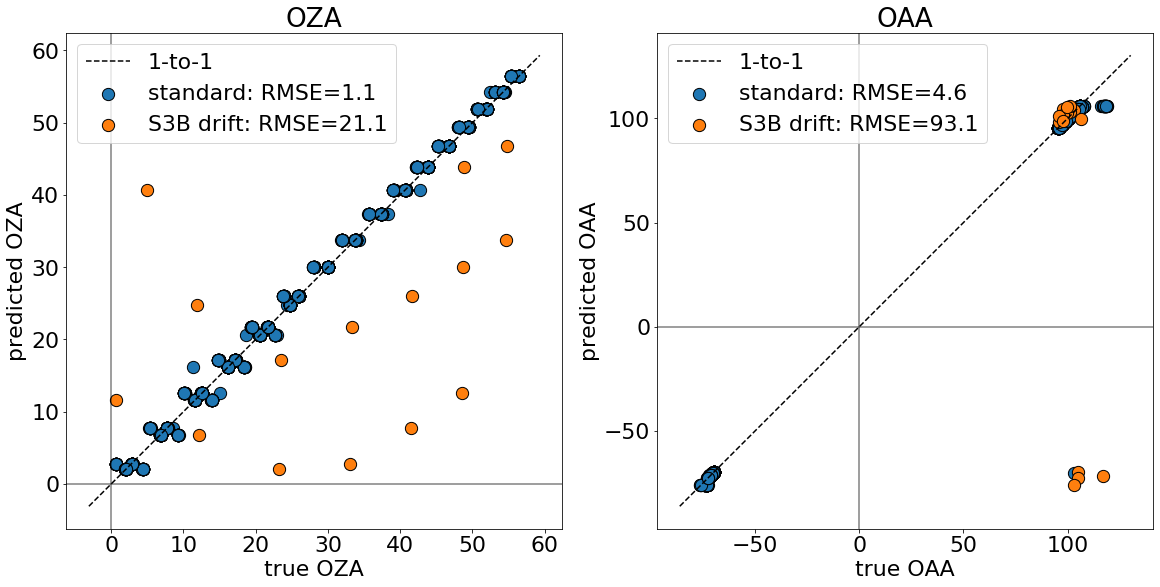

In [177]:
fig, axs = plt.subplots(1, 2, figsize=(16, 9), constrained_layout=True)

for i, ang in enumerate(['OZA', 'OAA']):
    ax = axs[i]
    x = df_angles.loc[common, ang]
    y = gee_angles.loc[common, ang]
#     if ang == 'OAA':
#         j = (x < 0) & (y < 0)
#         y[j] += 180
#         x[j] += 180
    res = foo.scatter_line_report(x=x[~broken], y=y[~broken], ax=ax, c='r', one2one=True, ms=15, alpha=1)
    res2 = foo.scatter_line_report(x=x[broken], y=y[broken], ax=ax, c='b', one2one=False, line=False, ms=15, alpha=1)
    
    ax.clear()
    ax.scatter(x[~broken], y[~broken], s=150, edgecolors='k')
    ax.scatter(x[broken], y[broken], s=150, edgecolors='k')
    abline(1, 0, ax)
    ax.legend(['1-to-1', f'standard: RMSE={round(res["rmse"], 1)}', f'S3B drift: RMSE={round(res2["rmse"], 1)}'])
    
    ax.axhline(alpha=0.5, c='k')
    ax.axvline(alpha=0.5, c='k')
    ax.set_title(ang)
    ax.set_xlabel(f'true {ang}')
    ax.set_ylabel(f'predicted {ang}')
    ax.set_aspect('equal', 'box')

# plt.savefig(r'D:\papers\gee_olci\proofread\figures\6_angles_spe2_cor.pdf')

Broken orbits belong to Tandem: 2018-05 to 2018-11

In [367]:
df_angles.loc[common][broken].sort_index()

,OZA,OAA
gee_name,,
S3B_20180515T101530_20180515T101830,4.995443,106.665321
S3B_20181026T100030_20181026T100330,23.544151,103.098747
S3B_20181027T093301_20181027T093601,48.863094,97.696342
S3B_20181029T101858_20181029T102158,0.668503,117.220299
S3B_20181030T095129_20181030T095429,33.306515,101.297256
S3B_20181031T092700_20181031T093000,54.763180,95.932533
S3B_20181102T100956_20181102T101256,12.138389,105.125229
S3B_20181103T094226_20181103T094526,41.634617,99.528107
S3B_20181106T100053_20181106T100353,23.250010,103.152107


In [405]:
gee.groundTrackDirection.value_counts()

descending    2043
Name: groundTrackDirection, dtype: int64

## Figure 9
### Solar

In [5]:
solar_cols = [x for x in df.columns if 'solar' in x]

In [6]:
df_my = df[solar_cols].groupby(df.index.dayofyear).mean().fillna(method='backfill')
df_my.index.name = 'DOY'
# df_my.to_csv(r"D:\PyCharm_projects\s3_6s_automated\db_peiqi\TOA_radiance_incoming\toa_irradiance_my.csv")

In [7]:
gee_solar = gee.reset_index().set_index(gee.index.dayofyear).join(df_my)

In [8]:
common = df.gee_name[df.gee_name.isin(gee['system:index'])]
df_esa = df.reset_index().set_index('gee_name').loc[common]
df_gee = gee_solar.reset_index().set_index('system:index').loc[common]

In [21]:
def plot_bands(axs, col_names, df_esa, df_gee):
    for i, band in enumerate(col_names):
        print('.', end='')
        ax = axs[i]
#         res = foo.scatter_line_report(x=df_esa[band], y=df_gee[band], ax=ax, c='r', one2one=True, ms=15, alpha=1)
#         ax.clear()
        x = df_esa[band]
        y = df_gee[band]
        rmse = np.sqrt(np.mean((x - y) ** 2))
        ax.hexbin(x, y, mincnt=1)
#         ax.set_title(f'{band.replace("solar_flux_", "")} \n RMSE={round(res["rmse"], 1)}')
        ax.set_title(f'{band.replace("solar_flux_", "")} \n RMSE={round(rmse, 1)}')
        ax.set_aspect('equal', 'box')
        ax.xaxis.set_major_locator(plt.MaxNLocator(2))
        ax.tick_params(axis='both', which='major', labelsize=14)
#         ax.tick_params(axis='both', which='minor', labelsize=8)
        #     ax.legend(['OZA', '1-to-1'])
        #     ax.set_xlabel('DHUS')
        #     ax.set_ylabel('GEE')

.....................

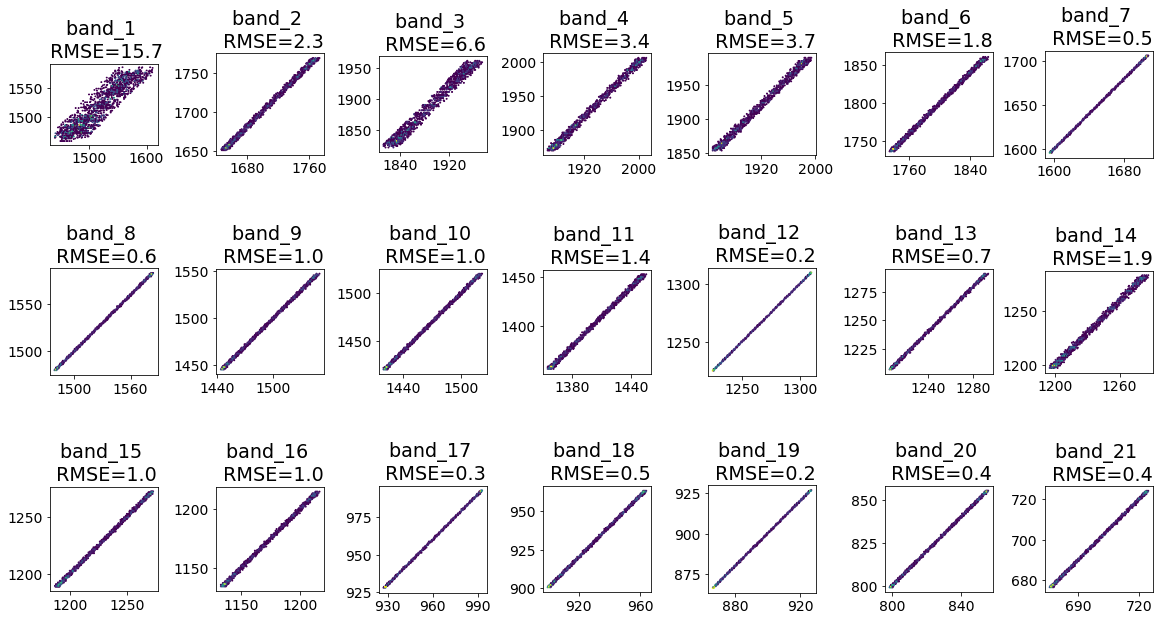

In [23]:
plt.rcParams.update({'font.size': 16})
# plt.locator_params(nbins=2)

fig, axs = plt.subplots(3, 7, figsize=(16, 9), constrained_layout=True)

axs = axs.flatten()
plot_bands(axs, solar_cols, df_esa, df_gee)

# plt.savefig(r'D:\papers\gee_olci\figures\solar_flux.pdf')

# Appendix
## Other products

requires even more data

## Figure A1
### MODIS

from GEE - https://code.earthengine.google.com/abeda236ca3783dd532c44e2fc7c6270?noload=true

official AppEARS - https://lpdaacsvc.cr.usgs.gov/appeears

In [2]:
app_refl = pd.read_csv(r"D:\PyCharm_projects\Spe\gee\vs_appears\reflectance\Spe-mod-refl-d-MCD43A4-006-results.csv", index_col='Date', parse_dates=True)
band_names_renamer = {x: x.replace('MCD43A4_006_Nadir_Reflectance_', '') for x in app_refl if 'Reflectance' in x}
app_refl = app_refl.rename(columns=band_names_renamer)

In [3]:
gee_refl = pd.read_csv(r"D:\PyCharm_projects\Spe\gee\vs_appears\reflectance\MCD43A4_spe.csv")
gee_refl.index = pd.to_datetime(gee_refl['system:index'].str[:10], format='%Y_%m_%d')
band_names_renamer = {x: x.replace('Nadir_Reflectance_', '') for x in gee_refl if 'Reflectance' in x}
gee_refl = gee_refl.rename(columns=band_names_renamer)

In [7]:
gee_refl.shape, app_refl.shape

((2080, 16), (1736, 55))

In [4]:
dates_in = app_refl.index[app_refl.index.isin(gee_refl.index)]
band_names = [f'Band{i}' for i in range(1, 8)]

.......

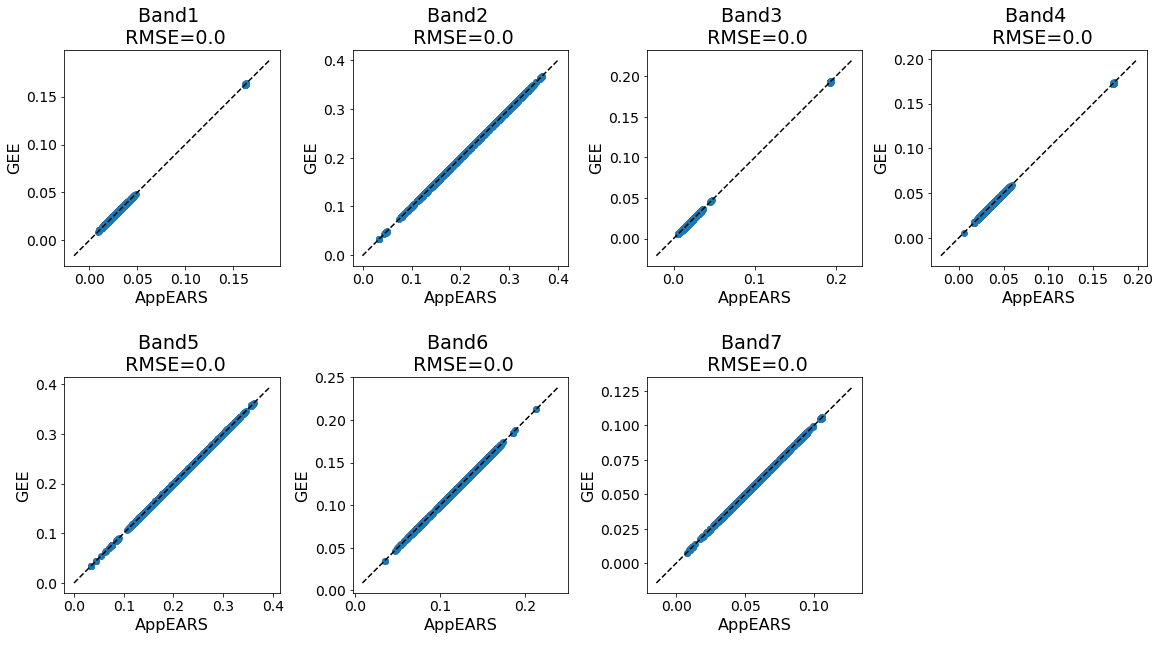

In [45]:
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(2, 4, figsize=(16, 9), constrained_layout=True)

axs = axs.flatten()
# plot_bands(axs, band_names, df_s2.loc[dt_in], gee_s2.loc[dt_in])

for i, band in enumerate(band_names):
    print('.', end='')
    ax = axs[i]
#         res = foo.scatter_line_report(x=df_esa[band], y=df_gee[band], ax=ax, c='r', one2one=True, ms=15, alpha=1)
#         ax.clear()
    x = app_refl.loc[dates_in, band]
    y = gee_refl.loc[dates_in, band] * 0.0001
    rmse = np.sqrt(np.mean((x - y) ** 2))
    ax.scatter(x, y)
    abline(1, 0, ax)
    ax.set_title(f'{band} \n RMSE={round(rmse, 2)}')
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('AppEARS')
    ax.set_ylabel('GEE')
    ax.tick_params(axis='both', which='major', labelsize=14)
fig.delaxes(axs[i+1])

# plt.savefig(r'D:\papers\gee_olci\figures\modis_match.pdf')

## Figure A2
### S2

GEE - https://code.earthengine.google.com/abeda236ca3783dd532c44e2fc7c6270?noload=true

Official - https://scihub.copernicus.eu/dhus/ or with `S3_loader`


In [12]:
def read_snap(pixels, products):
    df_pix = pd.read_csv(pixels, comment='#', sep='\t', index_col='ProdID')
    df_prod = pd.read_csv(products, comment='#', sep='\t', index_col='ProductID')
    df_prod['name'] = df_prod.ProductLocation.apply(lambda x: Path(x).with_suffix('').name)
    return df_pix.join(df_prod)

In [13]:
path = Path(r"D:\PyCharm_projects\Spe\gee\s2_gezira")
df_s2 = read_snap(path / 'PWA_20m_CF-1.4_measurements.txt', path / 'PWA_20m_productIdMap.txt')
df_s2.index = pd.to_datetime(df_s2['Date(yyyy-MM-dd)'] + ' ' + df_s2['Time(HH_mm_ss)'])
df_s2.shape

(71, 31)

In [14]:
gee_s2 = pd.read_csv(path / "gezira20m.csv")  # gezira20m.csv  gezira_s2.csv
gee_s2 = gee_s2[gee_s2['system:index'].str.contains('PWA')]  # the point also captured PWB
gee_s2.index = pd.to_datetime(gee_s2['system:index'].str[:15])
gee_s2.shape

(54, 25)

In [36]:
band_names = df_s2.columns[df_s2.columns.str.startswith('B')]
band_names

Index(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11',
       'B12'],
      dtype='object')

In [37]:
dt_in = df_s2.index[df_s2.index.isin(gee_s2.index)]

............

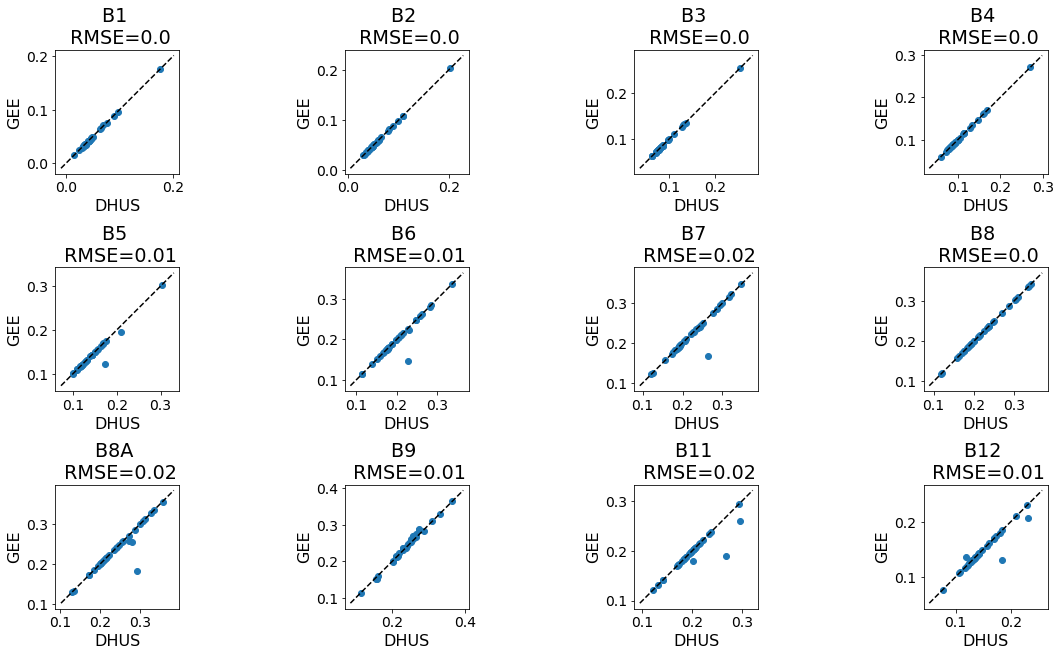

In [40]:
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(3, 4, figsize=(16, 9), constrained_layout=True)

axs = axs.flatten()
# plot_bands(axs, band_names, df_s2.loc[dt_in], gee_s2.loc[dt_in])

for i, band in enumerate(band_names):
    print('.', end='')
    ax = axs[i]
#         res = foo.scatter_line_report(x=df_esa[band], y=df_gee[band], ax=ax, c='r', one2one=True, ms=15, alpha=1)
#         ax.clear()
    x = df_s2.loc[dt_in, band]
    x[x==0] = np.nan
    y = gee_s2.loc[dt_in, band]
    rmse = np.sqrt(np.mean((x - y) ** 2))
    ax.scatter(x, y)
    abline(1, 0, ax)
    ax.set_title(f'{band} \n RMSE={round(rmse, 2)}')
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('DHUS')
    ax.set_ylabel('GEE')
    ax.tick_params(axis='both', which='major', labelsize=14)
    
# plt.savefig(r'D:\papers\gee_olci\figures\s2_20m-match1.pdf')